In [64]:
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install torch
!pip install matplotlib
!pip install scikit-learn gensim transformers sentence-transformers


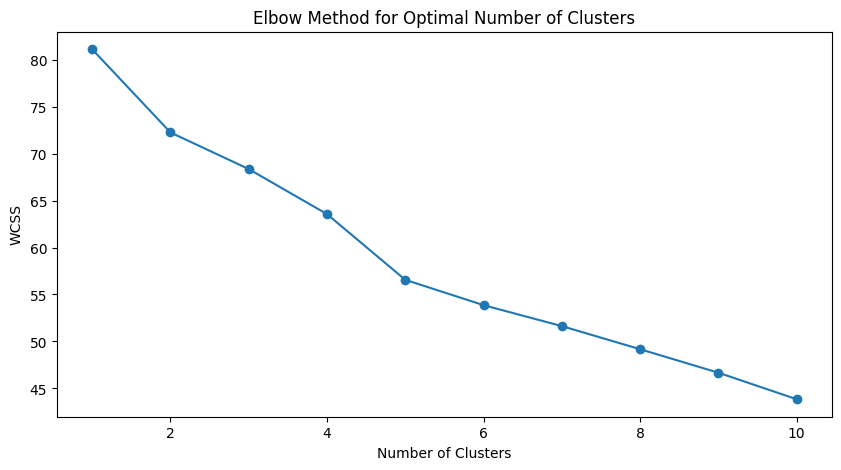

Cluster 0:
Top terms: ['domain', 'waveform', 'time', 'stimulus', 'output', 'representing', 'wave', 'sine', 'signal', 'equation']
Title: domain waveform time stimulus output representing wave sine signal equation
Claims in this cluster:
- 1. A system, comprising:a processor; anda memory that stores executable instructions that, when executed by the processor, facilitate performance of operations, comprising:obtaining a pressure-in to signal-out transfer function representing a distortion of an output signal of a microphone corresponding to an input stimulus of a defined sound pressure level (SPL) that has been applied to the microphone;creating an ideal sine wave stimulus based on an amplitude of a time domain waveform representing the output signal and a fundamental frequency of the time domain waveform;generating, based on a defined relationship between the ideal sine wave stimulus and the time domain waveform, an equation representing the pressure-in to signal-out transfer function r

In [3]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import silhouette_score


# Function to extract patent claims from URL
def extract_patent_claims(url):
    pages = requests.get(url)
    soup = BeautifulSoup(pages.text, 'html.parser')
    claims = soup.find_all('div', class_='claim-text')
    extracted_claims = []
    for claim in claims:
        text = claim.get_text(strip=True)
        extracted_claims.append(text)
    return extracted_claims

list_url = [
    'https://patents.google.com/patent/US9634864B2/en?oq=US9634864B2',
    'https://patents.google.com/patent/US9980046B2/en?oq=US9980046B2',
    'https://patents.google.com/patent/GB2478972A/en?q=(phone)&oq=phone']

claims = []
for url in list_url:
    claims.extend(extract_patent_claims(url))

lemmatizer = WordNetLemmatizer()

# Function to preprocess claims
def preprocess_claims(claims):
    stop_words = set(stopwords.words('english'))
    processed_claims = []
    
    for claim in claims:
        claim = claim.lower()
        claim = re.sub(r'[^a-z\s]', '', claim)
        tokens = word_tokenize(claim)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        processed_claims.append(' '.join(tokens))
    
    return processed_claims

# Preprocess claims
preprocessed_claims = preprocess_claims(claims)

# Convert a collection of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(preprocessed_claims)

# Elbow Method for Optimal Number of Clusters
def find_optimal_clusters(X_tfidf, max_clusters=10):
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(X_tfidf)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()
    return wcss

wcss = find_optimal_clusters(X_tfidf, max_clusters=10)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X_tfidf)
labels = kmeans.labels_

# Create a DataFrame for results
df = pd.DataFrame({'Claim': claims, 'Processed Claim': preprocessed_claims, 'Cluster': labels})

# Function to get the top terms for each cluster
def get_top_terms_per_cluster(kmeans, vectorizer, n_terms=10):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    top_terms = {}
    for i in range(num_clusters):
        top_terms[i] = [terms[ind] for ind in order_centroids[i, :n_terms]]
    return top_terms

# Get the top terms for each cluster
top_terms = get_top_terms_per_cluster(kmeans, vectorizer, n_terms=10)

# Function to get cluster titles based on top terms
def generate_cluster_titles(top_terms):
    cluster_titles = {}
    for cluster_num, terms in top_terms.items():
        title = " ".join(terms)
        cluster_titles[cluster_num] = title
    return cluster_titles

# Generate titles for each cluster
cluster_titles = generate_cluster_titles(top_terms)

# Print clusters, their corresponding top terms and claims
for cluster_num, terms in top_terms.items():
    print(f"Cluster {cluster_num}:")
    print("Top terms:", terms)
    print(f"Title: {cluster_titles[cluster_num]}")
    
    cluster_claims = df[df['Cluster'] == cluster_num]['Claim']
    print("Claims in this cluster:")
    for claim in cluster_claims:
        print(f"- {claim}")
    print("\n")


In [4]:
#Evaluation of the model - K mean
#silhouette score - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
silhouette_avg = silhouette_score(X_tfidf, labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")

Silhouette Score: 0.181
